In [1]:
!pip install -qU datasets transformers sentence-transformers \
                    pinecone-client pinecone-text protobuf==3.20.3

In [2]:
import os
import pinecone

api_key = "f20686d4-a194-4240-8672-595da7a89155"
env = "asia-southeast1-gcp-free"

pinecone.init(
    api_key=api_key,
    environment=env
)

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
index_name = "hybrid-image-search"

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        dimension=512,
        metric="dotproduct",
        pod_type="s1"
    )

In [4]:
index = pinecone.Index(index_name)

In [5]:
from datasets import load_dataset

fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)

fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [6]:
images = fashion["image"]
metadata = fashion.remove_columns("image")

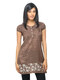

In [7]:
images[900]

In [8]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [9]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

In [10]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

In [11]:
bm25.fit(metadata["productDisplayName"])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [12]:
metadata["productDisplayName"][0]

'Turtle Check Men Navy Blue Shirt'

In [13]:
bm25.encode_queries(metadata["productDisplayName"][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596145,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.14930395560085577]}

In [14]:
bm25.encode_documents(metadata["productDisplayName"][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

In [15]:
from sentence_transformers import SentenceTransformer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SentenceTransformer(
    "sentence-transformers/clip-ViT-B-32",
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

In [16]:
dense_vec = model.encode([metadata["productDisplayName"][0]])
dense_vec.shape

(1, 512)

In [17]:
from tqdm.auto import tqdm

batch_size = 64

for i in tqdm(range(0, len(fashion), batch_size)):
    i_end = min(i + batch_size, len(fashion))
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(["id", "year"])].values.tolist()]

    img_batch = images[i:i_end]
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    dense_embeds = model.encode(img_batch).tolist()
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            "id": _id,
            "sparse_values": sparse,
            "values": dense,
            "metadata": meta
        })
    index.upsert(upserts)

index.describe_index_stats()

  0%|          | 0/689 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.2,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

In [18]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

In [19]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format="png")
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode("utf-8")}" style="width: 90px; height: 120px">
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {"".join(figures)}
        </div>
    ''')

In [20]:
print(len(imgs))

14



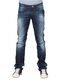
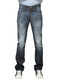
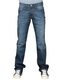
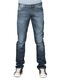
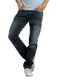
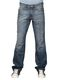
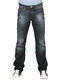
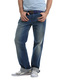
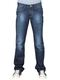
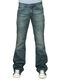
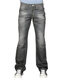
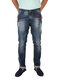
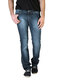
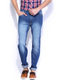

In [21]:
display_result(imgs)

In [22]:
def hybrid_search(dense, sparse, alpha):
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    hsparse = {
        "indices": sparse["indices"],
        "values": [v * (1 - alpha) for v in sparse["values"]]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse


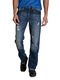
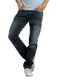
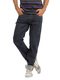
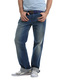
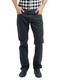
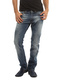
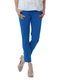
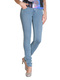
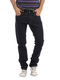
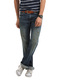
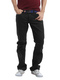
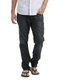
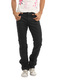
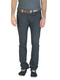

In [23]:
question = "dark blue french connection jeans for men"

hdense, hsparse = hybrid_search(dense, sparse, alpha=0)

result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [24]:
for x in result["matches"]:
    print(x["metadata"]["productDisplayName"])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans



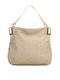
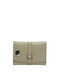
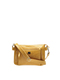
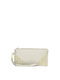
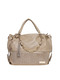
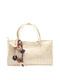
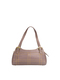
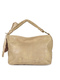
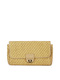
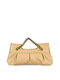
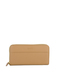
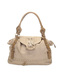
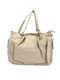
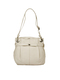

In [25]:
query = "small beige handbag for women"

sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

hdense, hsparse = hybrid_search(dense, sparse, alpha=0.5)

result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [26]:
for x in result["matches"]:
    print(x["metadata"]["productDisplayName"])

Rocky S Women Beige Handbag
Nyk Women Mushroom Brown Wallet
Nyk Women Mustard Biker Sling Bag
Mod'acc Women Light Grey Coin Purse
Lino Perros Women Beige Handbag
Kiara Women Beige Handbag
Murcia Women Mauve Handbag
Baggit Women Beige Handbag
French Connection Women Beige Weave Clutch
Baggit Women Golden Clutch
ToniQ Women Light Brown Wallet
Kiara Women Beige Handbag
Kiara Women Beige Handbag
United Colors of Benetton Women Cream Handbag


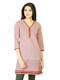

In [27]:
images[36254]


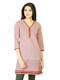
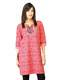
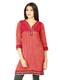
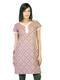
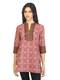
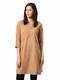
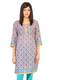
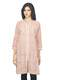
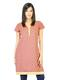
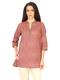
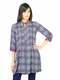
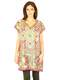
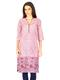
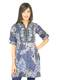

In [28]:
query = "soft purple topwear"

sparse = bm25.encode_queries(query)
dense = model.encode(images[36254]).tolist()

hdense, hsparse = hybrid_search(dense, sparse, alpha=0.3)

result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

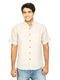

In [29]:
images[36256]


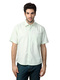
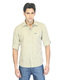
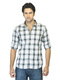
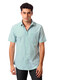
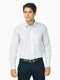
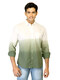
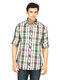
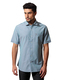
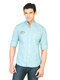
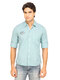
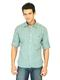
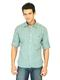
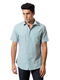
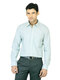

In [30]:
query = "soft green color topwear"

sparse = bm25.encode_queries(query)
dense = model.encode(images[36256]).tolist()

hdense, hsparse = hybrid_search(dense, sparse, alpha=0.6)

result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [31]:
pinecone.delete_index(index_name)